In [1]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

In [2]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_stacks_tall_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_stacks_tall_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(7819, 5)
means:  [-0.01102967  0.32073934 -0.02849547  0.200866    0.20438506]
vars:  [0.4484622  0.23035233 1.04938174 0.05754121 0.05745243]
2d_sphere : 
(1105, 4)
means:  [-0.00435995  0.34037243 -0.24383675  0.10027824]
vars:  [0.49857216 0.25986996 3.84608937 0.02914961]


In [3]:
print len(scenes_dataset_yaml)

1368


In [4]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TRAIN, max_num_objects=20)
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TEST, max_num_objects=20)
data_test = scenes_dataset_test.get_full_dataset()

print "Train # batches: ", data.batch_size
print "Test # batches: ", data_test.batch_size

Train # batches:  1368
Test # batches:  342


In [7]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)
        
print "All params: ", pyro.get_param_store().get_all_param_names()
#interesting_params = ["keep_going_weights",
#                      "new_class_weights"]

model = MultiObjectMultiClassModelWithContext(scenes_dataset)
pyro.clear_param_store()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_stacks_untrained.pyro")
guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

optim = pyro.optim.Adam({'lr': 0.001, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, guide, optim, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(2001):
    # Guesses on important things:
    # Big subsamples appear really important -- I had major loss of
    # convergence when using smaller subsample sizes (like ~50).
    # Also important: prior on the variance must be REALLY low.
    # Otherwise long_box_mean diverges to negative... :(
    # I think there's a fundamental problem with variance estimation
    # under this guide / with this system -- see the single-box-dataset
    # estimates that don't capture the x vs y variance.
    loss = svi.step(data, subsample_size=250) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=25) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 10:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    if (i % 10 == 0):
        print loss, best_test_loss
print "Done"

All params:  ['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$bias_hh_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generator_module_1$$$2.weight'

In [8]:
# Load in best state
print("Before state: ", pyro.get_param_store().get_state())
pyro.get_param_store().set_state(best_on_test_loss)
model = MultiObjectMultiClassModelWithContext(scenes_dataset)
print("After state: ", pyro.get_param_store().get_state())

('Before state: ', {'params': {'class_vars_generator_module_0$$$0.bias': Parameter containing:
tensor([-1.0693e-01, -4.4110e-02,  1.7652e-01, -6.8263e-02,  1.6803e-01,
        -4.5470e-03, -1.1239e-01,  1.6466e-01,  1.5011e-01,  9.0512e-02,
        -3.6287e-02,  2.3842e-01, -6.9044e-02, -6.0297e-02, -2.8865e-02,
        -3.3658e-02,  2.1408e-01, -1.0179e-01,  9.7105e-02,  1.6072e-01,
         1.7804e-01,  1.4363e-04,  1.6263e-01,  1.5836e-01, -3.7176e-02,
        -7.4041e-02, -4.0129e-02,  2.2271e-01,  2.1540e-01,  1.8767e-01,
         1.6880e-01,  1.9024e-01,  2.0709e-01,  1.5968e-01, -9.9313e-02,
         1.0629e-01,  1.7572e-01, -2.0864e-02, -5.4298e-02, -3.7003e-03,
        -7.1646e-02, -8.9261e-02, -3.5059e-03,  1.6716e-01,  1.5759e-01,
        -3.6293e-02,  2.0722e-01,  2.4269e-01,  2.1725e-01,  1.9631e-01,
         2.1993e-01,  2.1947e-01,  1.2885e-01, -3.8096e-02,  1.4399e-01,
         1.7791e-01, -6.1498e-02, -6.9973e-02, -6.6168e-02, -3.5315e-02,
        -4.7510e-02, -3.4590e

In [9]:
# Save model
# This isn't working and I'm not sure why...
print pyro.get_param_store().get_all_param_names()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_stacks_unstructured.pyro")

['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_controller_module$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_encoder_module_1$$$0.bias', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$4.weight', 'class_vars_generator_module_1$$$2.bias', 'class_means_generator_module_1$$$2.bias', 'class_means_generator_module_0$$$2.bias', 'context_updater_module$$$bias_hh_l0', 'class_means_generator_module_0$$$0.bias', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_vars_generator_module_1$$$2.weight', 'class_cont

In [32]:
# Load model
pyro.clear_param_store()
pyro.get_param_store().load("planar_multi_object_multi_class_2_with_context_stacks_unstructured.pyro")
model = MultiObjectMultiClassModelWithContext(scenes_dataset)
model.model()

(VectorizedEnvironments(batch_size=1, keep_going=tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]],
        dtype=torch.uint8), classes=tensor([[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]]), params_by_class=[tensor([[[-3.9095e-01,  1.7387e-01,  2.2332e-01,  2.0970e-01,  2.0223e-01],
          [-3.2008e-03,  5.0374e-01,  1.8340e-01,  2.5644e-01,  1.5347e-01],
          [-2.7015e-01,  5.3764e-01,  6.2237e-01,  1.8085e-01,  9.9746e-02],
          [-1.5580e-01,  3.4505e-01, -1.8048e-01,  2.1103e-01,  1.7437e-01],
          [ 2.9742e-01,  2.9420e-01,  2.4109e+00,  2.5508e-01,  2.0937e-01],
          [-1.1792e-01,  2.5181e-01, -1.9288e-01,  1.8046e-01,  2.0876e-01],
          [ 7.2342e-02,  1.3872e-01,  5.3619e-01,  3.2706e-01,  2.3718e-01],
          [ 1.3226e-02, -6.4553e-02, -6.7797e-01,  2.4940e-01,  2.5448e-01],
          [-5.1337e-01,  1.8628e-01,  5.8504e-01,  2.5547e-01,  2.6599e-01],
          [-6.4772e-03,  1.1927e-01,  2.5824e-01,  2.0716e-01, 

In [10]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_bin")
    time.sleep(1.0)

{'obj_0002': {'color': [0.6765706883659871, 0.0, 1.0, 1.0], 'pose': [0.21571385860443115, 0.522465169429779, 0.3585885763168335], 'params': [0.1840728521347046, 0.22705376148223877], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0003': {'color': [0.790624916213178, 0.0, 1.0, 1.0], 'pose': [-0.08212664723396301, 0.46958914399147034, 5.596591472625732], 'params': [0.07344399392604828], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.5096548931642026, 0.0, 1.0, 1.0], 'pose': [-0.1269369125366211, 0.10574902594089508, -0.04300808906555176], 'params': [0.1746520698070526, 0.23216024041175842], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.6717694136957824, 0.0, 1.0, 1.0], 'pose': [0.02022913098335266, 0.07635621726512909, -0.4942759573459625], 'params': [0.1615755558013916], 'class': '2d_sphere', 'params_names': ['radius']}, 'n_objects': 4}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You ca

{'obj_0002': {'color': [0.6112659431016091, 0.0, 1.0, 1.0], 'pose': [-0.6510651707649231, 0.41211172938346863, 1.4282532930374146], 'params': [0.09819813072681427], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0003': {'color': [0.6264085045239742, 0.0, 1.0, 1.0], 'pose': [-0.23778893053531647, 0.4663069248199463, 6.545510768890381], 'params': [0.08654196560382843], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.6331302546912703, 0.0, 1.0, 1.0], 'pose': [-0.139134481549263, -0.04226338863372803, 0.2178131639957428], 'params': [0.21774449944496155, 0.25085923075675964], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.7721854946098561, 0.0, 1.0, 1.0], 'pose': [-0.06163300946354866, 0.15958602726459503, -0.8728779554367065], 'params': [0.2596808075904846, 0.12564659118652344], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0006': {'color': [0.5514051792035609, 0.0, 1.0, 1.0], 'pose': [0.9386798143386

{'obj_0002': {'color': [0.6350177029928931, 0.0, 1.0, 1.0], 'pose': [-0.01788109540939331, 0.4665636420249939, -0.32060620188713074], 'params': [0.08735956251621246], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.6934644043158706, 0.0, 1.0, 1.0], 'pose': [0.5669734477996826, 0.02957124263048172, 0.981486439704895], 'params': [0.28579598665237427, 0.17942968010902405], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.763359123352113, 0.0, 1.0, 1.0], 'pose': [0.6502972841262817, 0.1691938042640686, -0.3070186972618103], 'params': [0.22814029455184937, 0.10770383477210999], 'class': '2d_box', 'params_names': ['height', 'length']}, 'n_objects': 3}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
{'obj_0002': {'color': [0.6385820933537292, 0.0, 1.0, 1.0], 'pose': [-0.3211268186569214, 0.5752252340

[18, 10, 14, 3, 9, 14, 8, 8, 16, 14, 5, 7, 6, 9, 11, 7, 11, 4, 11, 13, 14, 7, 10, 7, 5, 11, 14, 8, 5, 18, 6, 12, 7, 16, 14, 12, 4, 17, 2, 14, 6, 13, 6, 17, 3, 4, 15, 15, 15, 10, 4, 16, 4, 8, 17, 14, 4, 14, 17, 7, 9, 3, 5, 18, 15, 16, 9, 20, 8, 6, 12, 3, 7, 7, 3, 11, 9, 9, 6, 8, 20, 11, 17, 10, 12, 4, 4, 10, 7, 8, 3, 20, 11, 9, 15, 13, 3, 4, 13, 15, 8, 3, 15, 7, 12, 3, 18, 11, 10, 3, 8, 18, 10, 11, 9, 20, 15, 13, 4, 8, 4, 7, 11, 12, 2, 7, 7, 8, 12, 13, 5, 15, 8, 10, 15, 19, 11, 12, 13, 12, 7, 9, 12, 13, 9, 6, 7, 10, 3, 9, 10, 3, 5, 12, 10, 8, 12, 14, 4, 11, 12, 9, 5, 9, 13, 4, 6, 10, 9, 12, 4, 2, 15, 11, 10, 7, 18, 12, 17, 4, 8, 19, 3, 10, 8, 12, 3, 7, 11, 2, 7, 17, 14, 8, 9, 16, 4, 2, 14, 17, 5, 4, 14, 5, 3, 5, 15, 2, 3, 12, 15, 6, 7, 3, 10, 14, 3, 12, 6, 5, 3, 16, 15, 13, 6, 17, 15, 11, 12, 10, 14, 5, 11, 20, 12, 5, 10, 7, 13, 9, 7, 11, 3, 12, 11, 13, 11, 6, 4, 2, 14, 13, 11, 13, 18, 13, 4, 9, 9, 12, 7, 12, 19, 3, 11, 3, 9, 9, 6, 13, 11, 8, 16, 14, 3, 11, 20, 4, 20, 13, 10, 9, 8, 12, 

(array([ 0.,  1., 15., 43., 38., 25., 24., 36., 32., 38., 37., 43., 41.,
        29., 25., 21., 13., 13., 17.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

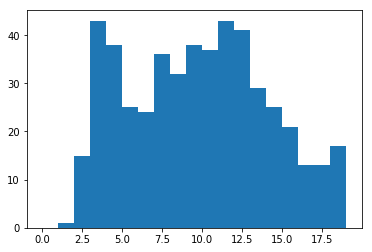

In [11]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(500):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    generated_n_objs.append(scene_yaml[0]["n_objects"])
print generated_n_objs
plt.hist(generated_n_objs, bins=range(20))

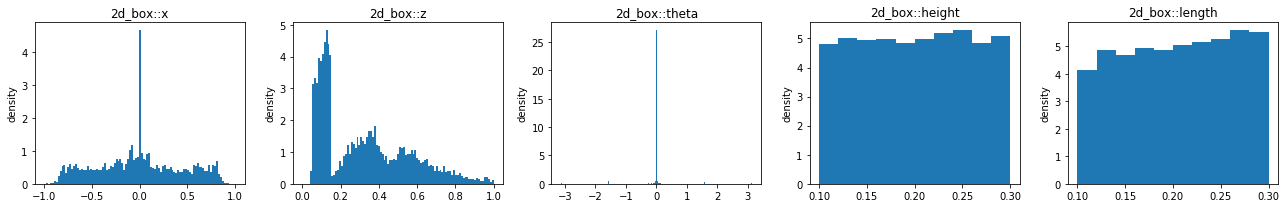

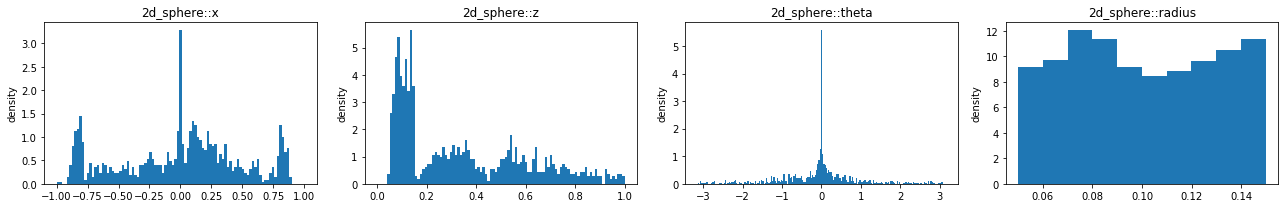

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm

for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    params = np.stack(params_by_object_class[object_name]).copy()
    #params[2, :] = (params[2, :] % np.pi)
    for k in range(params.shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, params.shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        x_bins = plt.hist(params[:, k], label="Empirical", density=True, bins=bins)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        #plt.plot(x_range, norm.pdf(x_range, params_means[k], params_vars[k]), label="Learned")
        
    plt.tight_layout()
    

In [13]:
import scipy as sp
import scipy.stats
# Draw the keep_going CDF, which is the product of all previous keep_going vals.
keep_going_vals = pyro.param("keep_going_weights").detach().numpy().copy()
keep_going_pdf = np.zeros(keep_going_vals.shape[0])
for k in range(0, keep_going_pdf.shape[0]):
    keep_going_pdf[k] = np.prod(keep_going_vals[0:k])*(1. - keep_going_vals[k])
plt.figure().set_size_inches(12, 3)
plt.title("Blue: Empirical dist of # objects, Orange: Fit dist of # of objects (geometric)")
plt.xlabel("# of objects")
plt.ylabel("Density")
xbins = plt.hist([p["n_objects"] for p in scenes_dataset_yaml], bins=range(0, 21), density=True)[1]
plt.plot(xbins, sp.stats.geom.pmf(xbins, 1.-keep_going_vals[0]))
plt.xticks(range(20))
plt.tight_layout()

KeyError: 'keep_going_weights'

In [20]:
import yaml
noalias_dumper = yaml.dumper.SafeDumper
noalias_dumper.ignore_aliases = lambda self, data: True

while (1):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
        generated_data)[0]
    try:
        scene_nonpen, scene_static = dataset_utils.ProjectEnvironmentToFeasibility(
            scene_yaml, "planar_bin")

        #print "Scene original"
        #dataset_utils.DrawYamlEnvironment(
        #    scene_yaml, "planar_bin",
        #    zmq_url="tcp://127.0.0.1:6001")
        #time.sleep(0.5)
        #print "Scene nonpen"
        #dataset_utils.DrawYamlEnvironment(
        #    scene_nonpen, "planar_bin",
        #    zmq_url="tcp://127.0.0.1:6001")
        #time.sleep(0.5)
        #print "Scene static"
        #dataset_utils.DrawYamlEnvironment(
        #    scene_static, "planar_bin",
        #    zmq_url="tcp://127.0.0.1:6001")

        for k in range(scene_static["n_objects"]):
            obj_yaml = scene_static["obj_%04d" % k]
            # Check if x or z is outside of bounds
            pose = np.array(obj_yaml["pose"])
            if pose[0] > 1.2 or pose[0] < -1.2 or pose[1] > 2.0 or pose[1] < 0.0:
                raise ValueError("Skipping scene due to bad projection.")

        env_name = "env_%d" % int(round(time.time() * 1000))
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_raw.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_yaml}, file, Dumper=noalias_dumper)
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_nonpen.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_nonpen}, file, Dumper=noalias_dumper)
        with open("generated_planar_bin_static_scenes_with_context_stacks_tall_static.yaml", "a") as file:
            yaml.dump({env_name:
                      scene_static}, file, Dumper=noalias_dumper)

    except Exception as e:
        print "Unhandled exception: ", e

Initial guess:  [-5.30137978e-02 -2.85454422e-01 -7.93272614e-01 -5.17971694e-01
 -5.87359548e-01 -6.52043939e-01 -4.32200253e-01  1.45380767e-02
 -1.87225640e-04 -4.77689892e-01 -1.15522802e-01 -1.80025250e-01
  3.70991349e-01  4.42748278e-01  3.95946503e-01  6.66411519e-02
  2.65640438e-01  8.12031478e-02  4.65786934e-01  4.33733940e-01
  1.55718744e-01  3.95115465e-01  4.50926661e-01  4.36738491e-01
  3.40635717e-01  4.37356353e-01  1.51695251e-01  1.70873970e-01
  2.06627309e-01  3.03175241e-01 -8.92003417e-01 -1.08519959e+00
  2.00769588e-01 -1.13382614e+00 -4.34139061e+00 -1.79678416e+00
  2.92854714e+00 -4.81331587e-01 -9.23959792e-01 -2.04863262e+00
  2.89968908e-01 -4.26344156e-01 -3.30076885e+00  1.25317872e+00
 -5.07958651e+00]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.0464756  -0.31020679 -0.81479762 -0.55451065 -0.69527914 -0.64833136
 -0.39189663  0.10192776  0.10441068 -0.52317984 -0.17106648 -0.22374889
  0.33182933  0.48932007  0.38853673  0.14932569  0.32250367 

Initial guess:  [-0.06012402 -0.07909104  0.67483991  0.70316267  0.16130173  0.59761912
  0.00368077  0.28403181  0.28228652  0.412633    0.0676671   0.04380892
  0.61292994 -1.44261098  0.52634913 -0.84471369  0.01308156 -2.64964223]
Used solver:  SNOPT/f2c
Success?  True
qf:  [-0.12738212 -0.01183294  0.67043048  0.71123927  0.16130173  0.59395196
  0.17365726  0.38031787  0.25018831  0.45271587  0.15274996  0.08366849
  0.60973451 -1.44261098  0.52634913 -0.84471369  0.00441647 -2.64964223]
Initial guess:  [ 0.12337039  0.67697769 -0.69130147 -0.05015244  0.12728351 -0.25609797
  0.54694396 -0.07467178 -0.07053306 -0.10007402  0.12168771  0.10628114
  0.32477692  0.82073969  0.27161229  0.26590708  0.38812783  0.39441228
  0.28451794  0.26412988  0.21830532  0.09357069  0.29496953  2.30418754
  4.50530958  0.92093122  0.87366802  3.17136955 -0.37009832  0.10563517
 -0.02941181 -0.07642406 -0.16805908]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.20376862  0.70773677 -0.69130147 

Used solver:  SNOPT/f2c
Success?  True
qf:  [-0.19976639 -0.37507363 -0.2132787  -0.10763476 -0.56553975  0.46445909
  0.75814979 -0.00943033  0.19052196  0.09542892  0.1767562   0.25235149
  0.5233304   0.18545029  0.20010916  0.56234922  0.07717081  0.23595472
  0.20426768  0.35102561  0.47630184  0.57266854  0.17585467  0.3968193
  0.32068525  0.52095184  0.46553129 -1.78077197  3.59541464 -1.79188
 -1.65064168  3.23169923 -0.60176437 -1.68946766 -2.58151817  2.79383206
 -2.45104599  1.32758677 -1.92849159]
Initial guess:  [ 0.19021076  0.08460198  0.28667632  0.22322552  0.08401638 -0.07777765
 -0.33885348 -0.24971035 -0.07781574 -0.31987804  0.32409006  0.44013143
  0.44904453  0.86358047  0.03698421  0.37881666  0.29465011  0.26372278
  0.18266259  0.34264261 -0.27329263 -0.31021473  0.21067631 -1.46545136
 -0.61307436 -0.91994345 -0.01152    -0.23389763  0.15771225 -0.54010177]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.27413089  0.13858396  0.38623069  0.22322552  0.071607

Used solver:  SNOPT/f2c
Success?  True
qf:  [-0.09051423 -0.43810584 -0.79090078 -0.67517849 -0.37048888 -0.1933792
  0.56440562  0.1209442   0.18659196 -0.06543352  0.16210192  0.36856136
  0.15654428  0.41405306  0.16466802  0.35947941  0.10707302  0.2195331
  0.49162521  0.54241301 -0.49333984 -1.18198895 -0.64112181  1.85863376
 -0.64653007  0.93549467 -0.224357   -0.91417873  0.09768257  1.31359065]
Initial guess:  [-0.03724743 -0.21266542 -0.31564665 -0.37528697 -0.07878997 -0.30480373
 -0.04958341  0.75311387 -0.39978653 -0.34190148 -0.66359949  0.60657048
  0.0921686   0.25639406  0.33059949  0.22733578  0.51867276  0.13689514
  0.21337897  0.09346975  0.10037887  0.4301689   0.42938733  0.08677205
 -0.21091318  2.16919661 -1.04236436  4.75919628 -1.83177161  6.3421936
  3.36418653 -2.09357905  0.81012106  0.30446166  1.99939334 -4.76724148]
Used solver:  SNOPT/f2c
Success?  True
qf:  [-2.15975002e-02 -1.59516049e-01 -3.25655307e-01 -3.95362912e-01
 -7.86215651e-02 -2.51745859e

Initial guess:  [ 1.67517722e-01 -1.00548267e-02 -3.92417759e-02 -2.43855417e-01
 -2.75598407e-01  3.27598214e-01 -3.71830940e-01 -2.26063132e-01
 -1.02184623e-01 -3.30311567e-01  3.90234113e-01 -1.54805690e-01
  3.21423829e-01 -2.50367403e-01  3.19035530e-01  9.93153095e-01
  1.59761488e-01 -1.99715793e-03 -8.09661150e-02  2.85066187e-01
  3.27864289e-01  5.35327137e-01  2.16565952e-02  5.93178391e-01
  7.91270137e-01  2.13085487e-01  2.62437552e-01  2.93925226e-01
  8.03535730e-02  4.72178757e-02 -5.37659973e-02  2.96052933e-01
  4.07413125e-01  3.77571702e-01  3.58827591e-01  4.06420708e-01
  1.72286838e-01  2.17663929e-01 -1.52478844e-01 -1.60984826e+00
 -4.27571154e+00  3.59208345e+00 -5.05352139e-01  4.97408772e+00
 -5.39972925e+00 -4.26475763e-01 -3.82878661e-01  1.25489020e+00
  1.55789280e+00  2.79529303e-01 -3.53501111e-01 -8.03933382e-01
  2.59094059e-01 -2.78684235e+00  1.29427120e-01  6.77370250e-01
 -3.46904397e+00]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 1.54406103

Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.50681546  0.48359238  0.44868356  0.9         0.76308826 -0.45417134
 -0.05293789  0.27706752  0.19434225 -0.42129839 -0.59649971 -0.33520523
 -0.02840601 -0.22416951 -0.38529907 -0.79615809  0.80267478  0.29397208
 -0.19456837  0.11635759  0.14606121  0.45144306  0.73657424  0.74542812
  0.46050629  0.04320418  0.13545554  0.61439616  0.17633131  0.15268367
  0.16302793  0.53841137  0.37222146  0.16739715  0.35365359  0.27237942
  0.14732522  0.41240324  0.53632846  0.50547781 -0.04760227 -0.22908123
  1.30955839  1.32738587 -4.05280557  4.291605    0.43457666 -0.1968419
  0.141578    0.62747669  0.0541484  -2.45235896  0.14157833  0.43457666
 -2.35750008 -0.21583119 -1.49224317 -6.55879879  0.1255401   0.31656949]
Initial guess:  [-0.06866463  0.04936758  0.5379824  -0.0153222  -0.0569607   0.09330557
 -0.14178243 -0.09308083  0.26167107  0.13961081  0.38166878  0.45599493
  0.3049176   0.37231183  0.12888873  0.01849905  0.10967285  0.

Initial guess:  [ 0.084723    0.10780214  0.29216656  0.6427567   1.08314049  0.14760393
  0.37053365  0.00405765  0.17065486  0.04082929  0.22097202  0.47436327
  0.37961516  0.32171413  0.15586616  0.12812293  0.21899289 -0.02147949
  0.02065719  0.73002386 -0.15988113 -0.22983941 -0.25357026 -0.01069252
  0.69774818  3.27774501 -1.48389494]
Used solver:  SNOPT/f2c
Success?  False
qf:  [-0.04323439  0.06632342  0.30537469  0.5868632   0.81127208  0.1414594
  0.48645232 -0.00907679  0.18356765  0.10486673  0.48415974  0.49098985
  0.43866638  0.27452685  0.33220763  0.19312339  0.27935832  0.12646502
  0.01505368  0.71455442 -0.15988113 -0.22983941 -0.25357026 -0.01718938
  0.70708377  3.27774501 -1.48389494]
Initial guess:  [-0.6363095  -0.8099094  -1.10590434 -0.81743467 -0.75016463 -0.75701505
  0.24789502  0.26954901  0.53567988  0.36462557  0.6790902  -0.0326685
 -0.69259548 -0.16438134 -0.00750876 -0.56290811  0.34577703  4.83344412]
Used solver:  SNOPT/f2c
Success?  True
qf:  [

Used solver:  SNOPT/f2c
Success?  False
qf:  [ 0.70324434  0.65497354  0.84330667  0.40330643 -0.36635754 -0.1741291
  0.41762619 -0.24879532 -0.2375607  -0.1551331   0.0579308   0.0426296
 -0.00563314  0.25196806  0.48981207  0.25308694  0.45877257  0.21166554
  0.35909688  0.14893205  0.2854138   0.58663961  0.10278173  0.47822861
  0.14839866  0.30135668 -0.09057834  0.5724529   0.04138547  1.44634065
  2.15171488 -1.73882328 -3.83253624 -0.52482948  0.63649314 -1.56607133
  0.73542339 -0.06438482  0.38767092]
Initial guess:  [ 0.63047206  0.35709238  1.16586196  1.27804756  0.56629801  0.29742789
  0.29439643 -0.06679578 -0.04157725  0.09180512  0.14108701  0.34779951
  0.3870137   0.38398826  0.58585954  0.33755583  0.15605009  0.23158354
  0.17177087  0.32997611 -0.80888575  1.10424066  1.27293754 -0.2847293
 -0.56409556 -0.52970916 -2.49733067  0.00816345  0.00626598 -0.12934178]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 6.30472064e-01  4.31132252e-01  7.98117271e-01  8.6531

Initial guess:  [ 0.91872311  0.90099835  1.02911747  0.32548371  0.32300138 -0.78747833
 -0.3807863  -0.03978206 -0.2167798   0.70003319  0.55607796  0.22844249
  0.39417386  0.03624433  0.37318107  0.17581835  0.2224464   0.15858838
  0.36555314  0.36508113  0.22050232 -0.01787406 -0.03920977  0.01032937
 -0.70310384 -0.56752735 -2.3967495   0.55584455  0.43029657  1.89865446
  7.31033468  0.13755909 -2.04835081]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 8.30983024e-01  8.86845148e-01  8.36677268e-01  2.60228807e-01
  2.85942193e-01 -7.87478328e-01 -3.80786300e-01 -3.17057151e-02
 -2.24856145e-01  5.51816799e-01  5.56077958e-01  3.27815417e-01
  5.72680618e-01  1.13322728e-01  4.76801048e-01  1.87608049e-01
  2.22446397e-01  1.58588380e-01  3.62810513e-01  3.67823760e-01
  3.27263560e-01  6.01358526e-02 -4.84994093e-13  1.18535308e-03
 -7.03103840e-01 -5.60875206e-01 -2.37746188e+00  5.55844545e-01
  4.30296570e-01  1.89816521e+00  7.31033468e+00  1.37559086e-01
 -2.04835081e+00]

Used solver:  SNOPT/f2c
Success?  True
qf:  [ 9.61215228e-02  6.40973806e-01  4.23396016e-01 -4.20920631e-01
  5.45732655e-01 -2.36564079e-01  4.22506655e-03  2.71507170e-01
  2.50836558e-01  1.74000409e-01  3.82132505e-01  4.57990543e-01
  2.55583009e-01  5.93727379e-01  4.63882545e-01  4.10439446e-01
  6.54880473e-01  3.57864369e-01  5.49055517e-01  1.17590618e+00
 -5.97330570e+00  2.64034534e+00 -1.56161439e+00 -1.13398445e-01
  2.62268068e-01 -1.42322564e+00  3.11778635e-01]
Initial guess:  [ 0.97890437  1.19971371  0.65859163  0.06626734  0.02129701  0.03145678
  0.32992613 -0.06629005  0.51192093  0.14295864  0.66633034 -0.87189937
 -0.03592872 -1.87351716 -3.11467004]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.77383806  0.79773788  0.65859163  0.06626734  0.02129701  0.16978808
  0.46499945  0.03486056  0.51192093  0.14295864  0.63611931 -0.87189937
 -0.03592872 -1.87351716 -3.11467004]
Initial guess:  [ 0.06629936  0.24144709  0.00665247 -0.07612917 -0.10715094  0.164353
 

Initial guess:  [-0.28376046  0.01608953 -0.27377564  0.27381819  0.29666927 -0.08059081
 -0.41804755 -0.32567525  0.35078532 -0.11927832  0.38706654  0.04836532
  0.5759173   0.22303267  0.20737933  0.15339415  0.30234233  0.0356387
  0.05704752  0.06037736  0.31457514  0.27745581  0.3441391   0.28391653
  0.21921209  0.23866467  0.11585239  0.44523257  0.02608295  0.13803083
  0.77309591 -1.67089641  1.96984482 -1.7692188   0.41773793  0.65459299
  0.63248503 -4.28887987  0.96660608  0.07463631  2.79482222 -0.14257029
 -0.50325131  0.09861204 -0.70802087]
Used solver:  SNOPT/f2c
Success?  True
qf:  [-0.58685986  0.14959455 -0.35729034  0.39386161  0.59205521 -0.06196407
 -0.79184381 -0.30456505  0.47235257 -0.06399257  0.37852028 -0.03140319
  0.68978611  0.19804508  0.20550914  0.42105076  0.59874945  0.19560059
  0.13596853  0.12741647  0.6852633   0.61546327  0.47937872  0.54632971
  0.41243563  0.30541989  0.14865713  0.33416314  0.10728175  0.34237731
  0.72344677 -1.67089641  1

Used solver:  SNOPT/f2c
Success?  False
qf:  [ 0.36396696  0.53972918  0.45639604 -0.21184916  0.81082474  0.64239663
 -0.0817049   0.22014712 -0.52076271 -0.57884663 -0.6468218  -0.41781116
 -0.15877983 -0.46011344 -0.01632527  0.13224035  0.39413573  0.04240747
  0.77040837 -0.25460504  0.09862559  0.0811958   0.27585469  0.50006805
  0.57048221  0.42757752  0.21939301  0.36515859  0.29634184  0.59946913
  0.38120859  0.41639355  0.32875572  0.15644755  0.4238699   0.14343852
  0.6621277   0.65738945  0.17959242  0.17328754  0.41021821 -4.94824791
  2.73878765  3.12599254  4.32540831  4.9229722  -4.03052282 -1.248954
  1.46868563 -1.436752   -1.14283833  2.13073085 -7.06826353 -0.44336576
  2.77042413  1.29547358  1.64590931  3.16571617  0.07851198 -0.36868797]
Initial guess:  [ 0.08968543  0.08980155  0.42051816  0.1061213   0.12329081  0.16007145
  0.30249947  0.39628422  0.42394626 -0.23072493  0.0902282   0.37359297
  0.20028844  1.22177637 -4.8563242 ]
Used solver:  SNOPT/f2c
Su

Initial guess:  [ 0.61525214  0.80978799  1.06499231  0.20168605 -0.13344477  0.42375547
  0.83282834  0.545367   -0.02305256  0.11698968  0.18944253  0.07252684
 -0.04788646  0.15971886 -0.07697588  0.36733848  0.09872114 -1.4871006
  0.10013297  2.37272549  3.10516906 -0.7288366  -0.86102521 -0.53299797]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.48821339  0.66613363  0.83955435  0.1363838  -0.13344477  0.35553825
  0.8531284   0.545367    0.11456446  0.16859163  0.2937214   0.15128175
  0.10019009  0.18187548  0.09687159  0.36733848  0.08187154 -1.4871006
  0.10013297  2.37522989  3.11635556 -0.7288366  -0.86102521 -0.53299797]
Initial guess:  [ 1.03252363  0.99119437  0.77106243  1.13573217  0.90712172 -0.2721166
 -0.09875149 -0.14870925  0.95272326  0.13169897  0.30416095  0.25374639
  0.32161337  0.19315481  0.38084528  0.30073318  0.44154298  0.21592209
  0.11198175  0.09820382 -0.43093351 -0.89686054 -2.35189939 -0.25592259
  0.60410839 -1.73272431 -0.63398582]
Used solver

Initial guess:  [ 3.84309471e-01  4.79291737e-01  8.99225473e-04  2.10806355e-01
  6.26528502e-01  1.60800084e-01  3.02745283e-01  1.76184371e-01
  5.39886355e-01  2.35790551e-01  3.36078078e-01 -6.93734348e-01
 -6.23486377e-02  1.89036858e+00 -2.14142275e+00]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 3.81138714e-01  4.72453085e-01  8.99225473e-04  2.10806355e-01
  6.36537910e-01  1.58161431e-01  3.09556766e-01  1.76184371e-01
  5.39886355e-01  2.31617720e-01  3.36259681e-01 -6.94059617e-01
 -6.23486377e-02  1.89036858e+00 -2.14142275e+00]
Initial guess:  [-0.19757113 -0.30554497  0.00909883 -0.52020967  0.33115038  0.33584702
 -0.0509715   0.15923837 -0.51761365  0.64279735  0.35250038  0.19682372
  0.37134731  0.37742627  0.28108948  0.35711047  0.25697482  0.28630385
  0.14816797  0.42840356  0.07603996  0.28726873 -0.85365778  1.2594192
 -1.43879008  3.48501921 -0.52086335 -0.12391977  0.00721494 -0.28002065
  1.00525558  0.93886656 -1.1617322 ]
Used solver:  SNOPT/f2c
Success?

Initial guess:  [ 0.50830519  0.33029178  0.57920676  0.31598932  0.52945232  0.37778661
 -0.10285398 -3.13583541  0.32221836]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.51969223  0.29984263  0.59826888  0.1888086   0.5325911   0.50182854
 -0.08929617 -3.13583541  0.32221836]
Initial guess:  [ 4.39978749e-01  4.12691414e-01  3.17356199e-01  9.95679617e-01
 -5.96871376e-02 -4.25577164e-03 -2.23110929e-01  7.34712481e-01
 -4.56544697e-01 -1.79417372e-01 -5.22563338e-01  9.25407782e-02
  3.34820479e-01  3.62925172e-01  4.29495096e-01  5.12829542e-01
  6.80103660e-01 -2.35676050e-01  5.51643558e-02  2.65698016e-01
  3.78227741e-01  5.15089631e-01  4.10436183e-01 -1.29718795e-01
 -1.94829136e-01 -3.65833305e-02  4.85976124e+00 -1.35905933e+00
  5.11314678e+00  7.86590457e-01 -1.02895522e+00 -8.48561347e-01
 -3.90576482e-01]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 4.39978738e-01  4.59551907e-01  2.70495717e-01  8.19215180e-01
 -2.31567274e-02  1.71907617e-03 -2.43984554e-01  7.347

Used solver:  SNOPT/f2c
Success?  False
qf:  [ 0.81454082  0.84608946  0.9         0.62900555  0.44304276 -0.28385944
 -0.57693503 -0.54862191 -0.25140006 -0.07163983  0.12941703 -0.1457338
  0.20501193  0.49930569  0.6762558   0.87323141  0.47035003  0.3853877
  0.25210285  0.47566735  0.11525324  0.15599468  0.23755342  0.62514663
 -0.15514702 -0.29797393 -0.24560576  5.58221245  3.6853826   2.01793981
 -0.12768826  1.2625879  -0.22718187 -0.03153396  0.12608868  0.67803824]
Initial guess:  [ 0.16953209 -0.37256867 -0.22818187  0.00484557  0.75613427  0.18425684
 -0.1691255   0.0907646   0.45704049  0.23980393  0.08601696  0.11123436
  0.23040679  0.18849978 -0.03770939  0.26039568  0.20822047  0.63630474
  0.47436082  0.27213794 -0.52839452 -2.79194713 -3.47252321  2.39466619
  2.2363379   2.06863284 -2.76495004 -1.33612847  0.1918177   3.95869493]
Used solver:  SNOPT/f2c
Success?  True
qf:  [ 0.23154076 -0.45101594 -0.22933662 -0.01282393  0.75613427  0.17734003
 -0.22355066  0.090

SystemExit: Failure at multibody/plant/multibody_plant.cc:1529 in CalcImplicitStribeckResults(): condition 'info == ImplicitStribeckSolverResult::kSuccess' failed.

In [21]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

scenes_dataset_yaml_static = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/notebooks/planar_bin/generated_planar_bin_static_scenes_with_context_stacks_tall_static.yaml")
params_by_object_class_static = generate_params_by_object_class(scenes_dataset_yaml_static)

scenes_dataset_yaml_nonpen = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/notebooks/planar_bin/generated_planar_bin_static_scenes_with_context_stacks_tall_nonpen.yaml")
params_by_object_class_nonpen = generate_params_by_object_class(scenes_dataset_yaml_nonpen)

print "Loaded %d successfully generated scenes." % len(scenes_dataset_yaml_nonpen)

Loaded 260 successfully generated scenes.


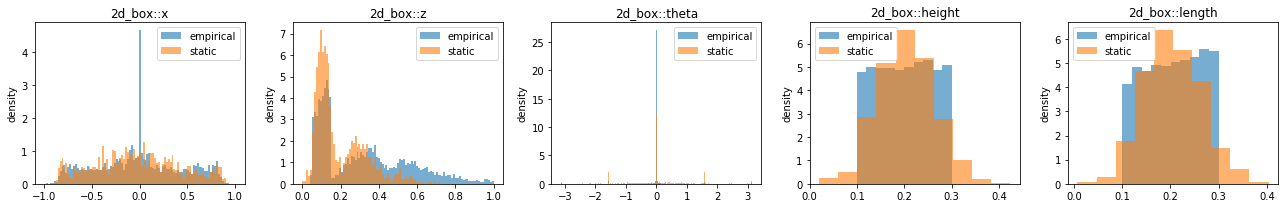

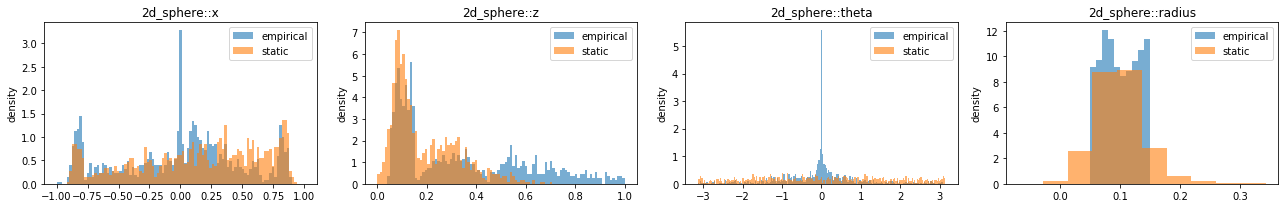

In [22]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        #params_by_object_class_nonpen[object_name],
        params_by_object_class_static[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "static"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()